# BEM and CCBlade NB
## The Analysis of an APC 10 x 7 Thin Electric Propeller using blade element momentum through the CCBlade.jl package
## Jacob Child


### Background:
A propeller blade can be analyzed by breaking the blade up into sections, computing the desired results at each section, and then summing the results to obtain the overall blade characteristics. CCBlade.jl is a package that makes using this method within Julia very streamlined and easy.

### Method/Pseudocode:
We desire to analyze and APC 10 x 7 thin electric propeller found [here](https://www.apcprop.com/product/10x7e/). We will first define the rotor characteristics and geometry, then define the characteristics of each section and the operating points, and lastly compute and plot the desired coefficients at various advance ratios.<br> The data for this propeller can be found on the UIUC website [here](https://m-selig.ae.illinois.edu/props/volume-1/propDB-volume-1.html#APC) - Found under "Thin Electric" it is the "10 x 7  [1]" ctrl+f for that exactly and you will find it under apc thin electric. More experimental data (used later in this notebook) is found on the manufacturer's website [here](https://www.apcprop.com/files/PER3_10x7E.dat)

### Assumptions:
The APC website says that their thin electric propellers are typically a mix of the Eppler E63 Low Reynolds Number Propeller and a Clark-Y similar airfoil towards the tip. As the location and details of the transition and twist is not known, we will assume it is an Eppler E63 airfoil along the whole blade. Data for that is found [here](http://airfoiltools.com/airfoil/details?airfoil=e63-il)

**Needed Packages** <br>


In [147]:
#Packages
using CCBlade, Plots, Statistics

**Define the rotor geometry and characteristics** <br>

In [148]:
#Define the Rotor
Rtip = 10/2 * .0254     #The tip radius is the diameter/2 and the converts in to meters
Rhub = .8/2 * .0254     #The hub radiaus is diameter/2 and can be found on the website
#Note: if not given on a website, look at the geometry file and the first point is r/R, or saying the current point 
# ... is 15% of the tip radius, so the hub has is less than that as the first point is on the blade itself and not the hub 
B = 2   #Number of blades
RPM = 5000.0  #The quick start guide uses 5400, but experimental data is only in 1000s on the website 

rotor = Rotor(Rhub, Rtip, B) #calls Rotor from the CCBlade package and stores a "Rotor" object
#fieldnames(typeof(rotor))

#Define the Prop geometry
#Taken from the UIUC database for this prop
#The first 2 columns are given in percent of Rtip (or Blade Tip Radius)

propgeom = [
0.15   0.138   37.86
0.20   0.154   45.82
0.25   0.175   44.19
0.30   0.190   38.35
0.35   0.198   33.64
0.40   0.202   29.90
0.45   0.200   27.02
0.50   0.195   24.67
0.55   0.186   22.62
0.60   0.174   20.88
0.65   0.161   19.36
0.70   0.145   17.98
0.75   0.129   16.74
0.80   0.112   15.79
0.85   0.096   14.64
0.90   0.081   13.86
0.95   0.061   12.72
1.00   0.040   11.53
]

r = propgeom[:, 1] * Rtip   #This gives the radial locations r in 5% steps along the blade
chord = propgeom[:, 2] * Rtip   #This gives the Chord length at each radial step/location 
theta = propgeom[:, 3] * pi/180     #the twist angle, converted from degrees to radians (what CCBlade wants)

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Airfoil Data** <br>
As discussed in the assumptions earlier, we are saying that it is an Eppler E63 airfoil applied across the whole blade. The data for this airfoil came from my ExtenderNSmoother code and is not corrected in any manner. The settings used were Re = 1000000, M = 0.0, Ncrit = 9

In [149]:
#Airfoil data
#Airfoil data needs to be imported, ie the lift and drag coef of the airfoil at different angles of attack (-pi to pi)
af = AlphaAF("EpplerE63Data.txt")   #this gives angle of attack, lift coefficient, drag coefficient
#... the top row has header info, then reynolds number, then mach number, on a dif row each

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Define the sections** <br>
The root of the Blade Element Momentum method is having each section to analyze. This will store the characteristics of each section, ie radial location, chord length, thetas to be analyzed, and the airfoil properties from above.

In [150]:
#Define sections to analyze
sections = Section.(r, chord, theta, Ref(af))   #the "." broadcasts to define all sections at once, and as the airfoil 
#... doesn't change af is wrapped in Ref to make it the same for each 
#fieldnames(typeof(sections[1]))

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Define Operating Points** <br>
This defines what the flow field conditions are at each section. Each "operating point" has the velocity components, density, pitch, mu (dynamic viscosity), and the speed of sound (for the Mach number I think)

In [151]:
#Define the operating points 
#Define the input airflow and broadcast to solve the velocity at each point 
Vinf = 5.0  #inflow velocity, this means that the solve done below is for a singular advance ratio
Omega = RPM*pi/30  #converts rpm to rad/s, derivation: rpm*pi*360deg/(60sec*180deg)-> rpm*pi/30
rho = 1.225     #density of the air in metric

op = simple_op.(Vinf, Omega, r, rho)    #calls simple_op to define "operating points" at each section
#fieldnames(typeof(op[1])) 

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Solve** <br>
With all the neccessary "elements" for BEM setup we can now solve using the solve function in the CCBlade package. What is output is a struct of results at each section/radial location. A list of all the struct outputs and definitions can be found [here](https://flow.byu.edu/CCBlade.jl/stable/reference/#Output-Struct)


In [152]:
out = solve.(Ref(rotor), sections, op)  #outputs a struct of results for each section/radial location

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Preparation for coefficient analysis and plotting** <br>
Efficiency ($\eta$), Coefficient of Thrust ($C_t$), and Coefficient of Torque ($C_Q$), are functions of the coefficents found above (the formulas are shown below). Each of these values that relies on a velocity or rpm is thus also a function of the Advance Ratio, or the ratio of forward speed divided by rotational speed. We will create a range of advance ratios (almost like a range of velocities in other domains) in order to plot and analyze later <br>
*Efficiency*
$$ \eta = \frac{P_{out}}{P_{in}} = \frac{TV}{Q\Omega} $$
*Explanation-* eta = Power output over power input, or Thrust times Velocity over Torque times rotational speed <br><br>

*Coefficent of Thrust*
$$ C_T = \frac {T}{\rho n^2 D^4} $$
*Explanation-* T = Thrust, rho = density of the fluid, n = propeller rotation rate in revolutions per second, D = propeller diameter <br><br>

*Coeffcient of Torque*
$$ C_Q = \frac {Q}{\rho n^2 D^5} $$
*Explanation-* Q = Torque, rho = density of the fluid, n = propeller rotation rate in revolutions per second, D = propeller diameter <br><br>

*Advance Ratio*
$$ J = \frac{V}{nD}  $$
*Explanation-* J = Forward velocity divided by n = revolutions per second, D = Diameter <br><br>
*Coeffcient of Power*
$$ C_p = \frac{P}{\rho n^3 D^5} $$
*Explanation-* P = Power, rho = density of the fluid, n = propeller rotation rate in revolutions per second, D = propeller diameter <br><br>

In [153]:
#Inputs
#nJ = 30     #number of advance ratios to evaluate
#J = range(0.00001, .92, length = nJ) #creates a range of advance ratios, what are normal vals?
nJ = 23
J = range(.376, .869, length = nJ)
RPM = 6519 #I am changing this to match uiuc, after, go back to 5000

Omega = RPM*pi/30  #rpms to rad/sec 
n = Omega/(2*pi)    # converts radians persecond to just rotations per second, same as rpm/60
D = 2 * Rtip    #Diameter of the prop is 2* the radius (note: Rtip is defined from center of rotation so includes Rhub)

eff = zeros(nJ)     #creates arrays for efficiency, coef of thrust, and coef of torque 
CT = zeros(nJ) #Coef of Thrust 
CQ = zeros(nJ)      #coef of torque 

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Solve for the coefficients** <br>
Each coefficient is going to be different at each advance ratio, and also at each section, or element, of the blade, so we will use a for loop to calculate all the needed values.

In [154]:
for i = 1:nJ
    local Vinf = J[i] * D * n   #makes a local inflow veloc var at each advance ratio 
    local op = simple_op.(Vinf, Omega, r, rho)  #creates op pts at each blade section/location
    
    outputs = solve.(Ref(rotor), sections, op) #uses all data from above plus local op conditions
    T, Q = thrusttorque(rotor, sections, outputs)   #calcs T & Q at each sec w/given conds, sums them for the whole rotor
    eff[i], CT[i], CQ[i] = nondim(T, Q, Vinf, Omega, rho, rotor, "propeller")
    # calcs the coef of the blade under the given conditions at each advance ratio
end

**Experimental Data to prepare to plot** <br>
Experimental data can be found both at the UIUC database and the APC database, I chose to go with the APC database as they are the manufacturer and also have more outputs should I desire to use them in the future. It can be found [here](https://www.apcprop.com/files/PER3_10x7E.dat) <br>
*Note:* This experimental data is specific to 5000 RPM (which is what I defined above), but data is available for other rpms.<br>
The data has the following heading structure <br>
V (mph) | J (Adv Ratio) | Pe (efficiency) | Ct | Cp | PWR (Hp) | Torque (In-Lbf) | Thrust (Lbf)


In [155]:
#Experimental data at the given Advance Ratio
#V (mph)|J(Adv Ratio)|Pe(efficiency)| --Ct--- | --Cp--- | PWR (Hp) | Torque (In-Lbf) | Thrust (Lbf)
#=
exp = [
    0.0        0.00      0.0000      0.1161      0.0549       0.055       0.695       0.925              
    1.5        0.03      0.0657      0.1159      0.0559       0.056       0.708       0.923              
    3.0        0.06      0.1286      0.1157      0.0569       0.057       0.722       0.921              
    4.5        0.09      0.1888      0.1153      0.0580       0.058       0.735       0.918              
    6.0        0.13      0.2462      0.1149      0.0591       0.059       0.749       0.915              
    7.5        0.16      0.3008      0.1143      0.0601       0.060       0.762       0.910              
    9.0        0.19      0.3527      0.1133      0.0610       0.061       0.774       0.902              
   10.5        0.22      0.4018      0.1119      0.0617       0.062       0.782       0.891              
   12.0        0.25      0.4481      0.1100      0.0622       0.063       0.788       0.876              
   13.5        0.28      0.4915      0.1077      0.0624       0.063       0.791       0.858              
   15.0        0.32      0.5318      0.1050      0.0625       0.063       0.792       0.836              
   16.5        0.35      0.5691      0.1018      0.0623       0.063       0.790       0.811              
   18.0        0.38      0.6033      0.0983      0.0619       0.062       0.785       0.783              
   19.5        0.41      0.6343      0.0945      0.0613       0.062       0.777       0.752              
   21.0        0.44      0.6620      0.0902      0.0604       0.061       0.765       0.718              
   22.5        0.47      0.6864      0.0855      0.0591       0.059       0.750       0.681              
   24.0        0.51      0.7076      0.0803      0.0575       0.058       0.729       0.640              
   25.5        0.54      0.7256      0.0749      0.0556       0.056       0.704       0.597              
   27.0        0.57      0.7406      0.0694      0.0534       0.054       0.677       0.553              
   28.5        0.60      0.7526      0.0637      0.0509       0.051       0.646       0.508              
   30.0        0.63      0.7624      0.0580      0.0482       0.048       0.610       0.462              
   31.5        0.66      0.7701      0.0521      0.0450       0.045       0.570       0.415              
   33.0        0.70      0.7755      0.0460      0.0413       0.042       0.524       0.366              
   34.5        0.73      0.7781      0.0398      0.0372       0.037       0.472       0.317              
   36.0        0.76      0.7773      0.0334      0.0327       0.033       0.414       0.266              
   37.5        0.79      0.7694      0.0269      0.0277       0.028       0.351       0.214              
   39.0        0.82      0.7468      0.0203      0.0224       0.023       0.284       0.162              
   40.5        0.85      0.6956      0.0136      0.0167       0.017       0.212       0.108              
   42.0        0.89      0.5648      0.0068      0.0107       0.011       0.136       0.054              
   43.5        0.92      0.0024      0.0000      0.0047       0.005       0.059       0.000 
]  

#Experimental value extraction
JExp = exp[:,2]     #Advanced ratio
CtExp = exp[:, 4] #Coef of Thrust
CpExp = exp[:, 5] #Coef of Power
EtaExp = exp[:, 3] #Efficiency
=#

#exp 2 = J       CT       CP       eta
#=
exp2 = [
0.487   0.0642   0.0464   0.675
0.514   0.0583   0.0441   0.681
0.547   0.0503   0.0401   0.686
0.575   0.0446   0.0372   0.690
0.605   0.0391   0.0342   0.692
0.633   0.0339   0.0314   0.683
0.663   0.0288   0.0285   0.668
0.690   0.0241   0.0259   0.643
0.726   0.0176   0.0221   0.579
0.752   0.0127   0.0191   0.500
0.785   0.0070   0.0154   0.358
0.810   0.0025   0.0124   0.167
0.841   -0.0034   0.0087   -0.324
    ]
=#
exp2 = [
0.376   0.0887   0.0536   0.621
0.397   0.0864   0.0535   0.642
0.419   0.0837   0.0532   0.659
0.439   0.0807   0.0527   0.672
0.465   0.0756   0.0513   0.685
0.486   0.0717   0.0502   0.695
0.507   0.0679   0.0490   0.704
0.530   0.0618   0.0464   0.707
0.549   0.0578   0.0446   0.711
0.575   0.0514   0.0414   0.714
0.595   0.0469   0.0392   0.712
0.625   0.0400   0.0353   0.707
0.644   0.0365   0.0334   0.703
0.669   0.0314   0.0305   0.688
0.687   0.0280   0.0286   0.673
0.704   0.0249   0.0267   0.656
0.734   0.0195   0.0234   0.610
0.752   0.0159   0.0212   0.563
0.778   0.0109   0.0179   0.473
0.797   0.0075   0.0156   0.383
0.821   0.0030   0.0125   0.195
0.844   -0.0014   0.0095   -0.129
0.869   -0.0063   0.0063   -0.878
]
JExp = exp2[:,1]
CtExp = exp2[:,2]
CpExp = exp2[:,3]
EtaExp = exp2[:,4]

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Plotting and Data Comparison** <br>
Convention will be followed with the figure caption below the plot. The discussion will also be below the given plot, this means in turn that the code for each plot will have to be above it.

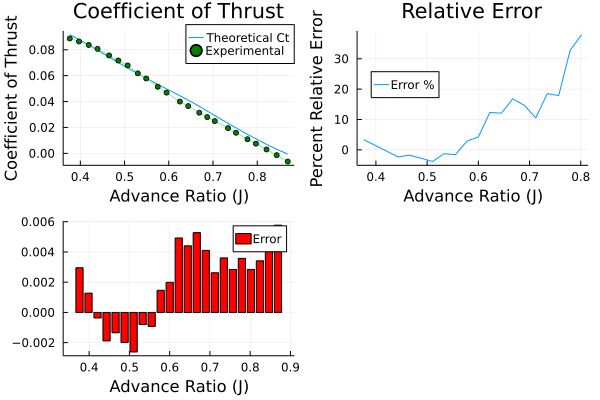

In [156]:
p1 = plot(J, CT, title = "Coefficient of Thrust", label = "Theoretical Ct")
plot!(JExp, CtExp, m = 3, xlabel = "Advance Ratio (J)", label = "Experimental", 
    markercolor = "green", linecolor = "lightgreen", ylabel = "Coefficient of Thrust",
    legend = (.62,.95));
MagError = (CT - CtExp)
p4 = bar(J, MagError, xlabel = "Advance Ratio (J)", label = "Error", legend = :topright, fillcolor = "red");

#Error Calculations
RelError = (CT - CtExp) ./ CtExp * 100
#p3 = plot(J[1:29],RelError[1:29], title = "Relative Error", xlabel = "Advance Ratio (J)", ylabel = "Percent Relative Error",
 #   label = "Error %", legend = (.15, .6))
p3 = plot(J[1:20],RelError[1:20], title = "Relative Error", xlabel = "Advance Ratio (J)", ylabel = "Percent Relative Error",
    label = "Error %", legend = (.15, .6))

plot(p1,p3,p4)

*Figure 1:* Experimental and theoretical coefficients of thrust plotted at different advance ratios <br><br>
**Discussion** <br>
The coefficient of thrust ($C_t$) is the ratio of output thrust to propeller theoretical potential thrust. It can be seen that the theoretical $C_t$ generally overpredicted the performance of the propeller and while it follows the same general curve/shape of the experimental data it doesn't semi - accurately predict until advance ratios above .7. It should be noted, that while the relative error appears large (-10 to over 15% off), that is a side effect of such small values. The error while not insignificant, is below .02 off, and at advance ratios above .8 are nearly dead on. This error mainly comes from the theoretical model not including losses that occur in real life. A more in depth explanation of this is given in the general discussion below, but the theoretical model assumes all flow is perpindicular to the rotating disc and that there aren't losses from other factors as well. This causes the theoretical model to be an overprediciton of the experimental results.

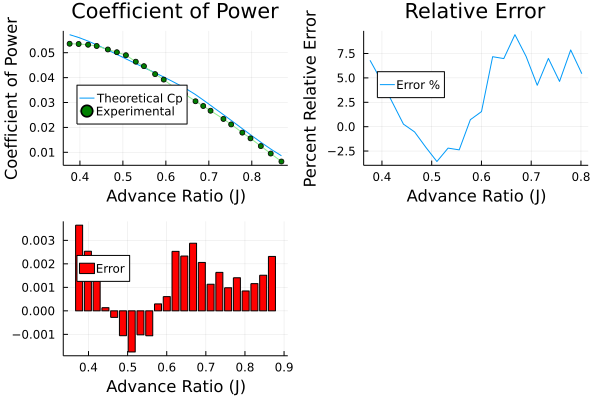

In [157]:
p1 = plot(J, CQ*2*pi, title = "Coefficient of Power", label = "Theoretical Cp",
    legend = :bottomleft) #CQ*2*pi converts coef of torque to coef pwr
plot!(JExp, CpExp, m = 3, xlabel = "Advance Ratio (J)", label = "Experimental", 
    legend = (.15,.5), markercolor = "green", linecolor = "lightgreen", ylabel = "Coefficient of Power");
MagError = (CQ*2*pi - CpExp)
p4 = bar(J, MagError, xlabel = "Advance Ratio (J)", label = "Error", legend = (.15, .65), fillcolor = "red");

#Error Calculations
RelError = (CQ*2*pi - CpExp) ./ CpExp * 100
#p3 = plot(J[1:29],RelError[1:29], title = "Relative Error", xlabel = "Advance Ratio (J)", 
#ylabel = "Percent Relative Error", label = "Error %", legend = :topleft)
p3 = plot(J[1:20],RelError[1:20], title = "Relative Error", xlabel = "Advance Ratio (J)", ylabel = "Percent Relative Error",
    label = "Error %", legend = (.15, .6))

plot(p1,p3,p4)

*Figure 2:* Experimental and theoretical coefficients of power plotted at different advance ratios <br><br>
**Discussion** <br>
One way to interpret $C_Q$ is how much power is used at a given moment, or the rate at which that power is used. While the theoretical calculations were very accurate above advance ratios of .7, the shape of the curve seems to be slightly narrower and shifted right. This means that while the theoretical calculations predict the best Coefficient of Power ($C_p$) to be at about .37, it is actually closer to .35. The absolute error at this point is well under .005. It is important to note that as the theoretical curve is shifted to the right, it yet again shows that the theoretical model over predicted the propeller power use, which means it under predicted performance (not by too much), however it also said that the worst performance would happen later (at higher advance ratios) than it actually did. In this case the error at low and high advance ratios can be explained by losses not being accounted for (like discussed above and below). This would cause more power to be consumed to overcome those losses at that advance ratio. In middle advance ratios the experimental model performed better than the theoretical model predicted. The source of this error could be from Reynolds number differences and other calculation differences discussed in the explanation below.

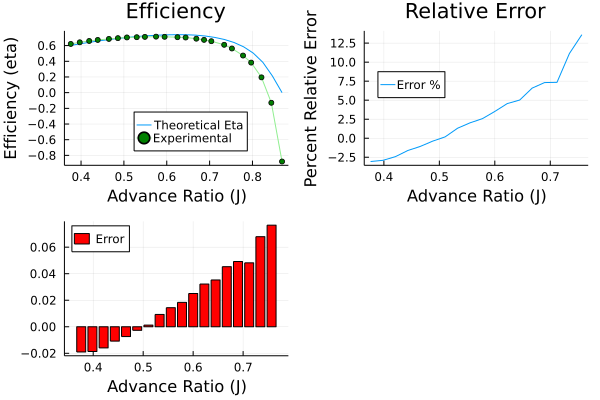

In [165]:
p1 = plot(J, eff, title = "Efficiency", label = "Theoretical Eta")
p2 = plot!(JExp, EtaExp, m = 3, xlabel = "Advance Ratio (J)", ylabel = "Efficiency (eta)",
    label = "Experimental", legend = (0.4,.3), markercolor = "green", linecolor = "lightgreen");
MagError = (eff - EtaExp)
p4 = bar(J[1:18], MagError[1:18], xlabel = "Advance Ratio (J)", label = " Error", legend = :topleft, fillcolor = "red");

#Error Calculations
RelError = (eff - EtaExp) ./ EtaExp * 100

#p3 = plot(J[1:29],RelError[1:29], title = "Relative Error", xlabel = "Advance Ratio (J)", 
#ylabel = "Percent Relative Error", label = "Error (%)")
p3 = plot(J[1:18],RelError[1:18], title = "Relative Error", xlabel = "Advance Ratio (J)", ylabel = "Percent Relative Error",
    label = "Error %", legend = (.15, .6))

plot(p1, p3, p4)

*Figure 3:* Experimental and theoretical efficiencies plotted at different advance ratios <br><br>
**Discussion**
The theoretical effeciency curve shape matches the experimental curve probably better than any of the other coefficients, however its peak absolute error is still around .075-.1. The "rising" portion of the efficiency curve matches quite well to the experimental data, showing that at low to medium advance ratios the theoretical effeciency is a decent prediciton. While the locations of max effeciency seem to match up, the theoretical effeciency was yet again over predicted. This error comes from the theoretical model not accounting for losses as was discussed in the $C_t$ section and in more depth below.

**Overall Results and Error Discusson** <br>
*Results Discussion:* <br>
The APC 10 x 7 thin electric propeller seems to be one that is designed for medium advance ratios. For instance, operating the propeller at an advance ratio of .4 (or a medium speed) would mean the propeller is operating at about 75% of its peak effeciency, drawing the most power, and about 85% of its thrust capacity. This means that even though it is at a max power draw it is quite effecient and has plenty of thrust if an increase of speed is desired. These are decent stats. It also would be a very effecient high speed cruising propeller- at high advance ratios it has low thrust and power use, but max effeciency. I would label this as a medium to high speed propeller meant to get up to speed quickly. It will give the best battery life at high speeds but can still accelerate quickly at medium speeds making it overall more suitable for faster flying. At low advance ratios it has less than max power draw and a high coefficient of thrust, however low effeciency. This means that it can quickly get up to speed, but staying at lower speeds would note be ideal as it is less effecient and would shorten the battery life.<br><br>
*Error Discussion:*<br>
The discrepencies between the theoretical and experiemental data values and curve shapes can come from several factors. The first and most notable is that this study was done with only an approximation of the propeller. The actual propeller is a combination of airfoils (Eppler E63 and Clark - Y) and the transition locations and exact geometry of the propeller etc are not actually known.The second is that in the theoretical case it was assumed that there were no losses. This means that all of the air flows directly into and out of the control volume perpindicular to the rotating plane, with no flow up or down. It also means that there are no losses due to heat transfer, noise (noise generation is a way energy is lost from a system), and compressibility (assuming an incompressible fluid means that each air particle pushes on the one next to it and can't be squeezed closer than a fixed distance). In actuality all of these losses occur in real life to some extent, and thus our theoretical model will over predict propeller performance. Another problem is that in the theoretical model some values had to be assumed. Both a Reynolds number and an Ncrit value had to be assumed, so and Re of 1,000,000 was chosen and an Ncrit of 9 for the theoretical model, but the experimental conditions could have been different (An estimation of the range of Reynolds numbers is found below). Another difference is that the theoretical model assumes perfect geometry, for example the blade is not going to have any flashing or defects and will be oriented exactly as the math says it is to be oriented. Errors could also come from the data calculated in Xfoil, if a higher resolution airfoil plot was used, the results might be different. All of these factors combined lead to the theoretical model over predicting actual performance. Other than improving the factors discussed above, another way to improve the accuracy of the model is using better airfoil data. Each blade/airfoil section is discretized, a higher discretization would make for more accurate calculations and thus, it is assumed, less error.

**Reynolds Number Calculation and Discussion** <br>
$$ Re = \frac {\rho V c}{\mu} $$ <br>
*Explanation-* Rho = density of the fluid, V = velocity of the fluid (free stream), c = relevant length scale (the chord for an airfoil or aerodynamic chord for a  wing), mu = dynamic viscosity of the fluid <br>
<br>
We also know that freestream velocity can be found from the advance ratio and rpm. <br>
$$ V_s = \frac {J*rpm*Rtip}{30}$$
<br>
Using all of the above we can calculate the range of Reynolds numbers that were used.

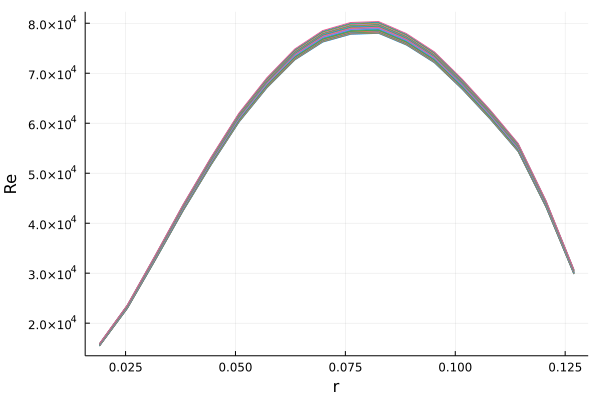

77981.9564029938
80336.97885639587
79016.51148587577
0.869


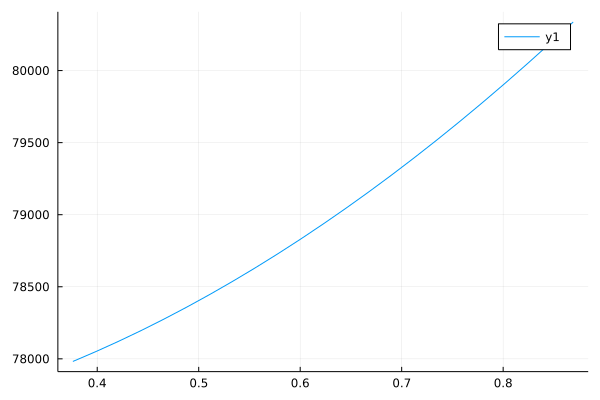

In [159]:
#Defining Variables for output
mu = 1.823*10^-5 #dynamic viscosity of air assuming room temp
Re = zero(J)
SectionRe = zero(chord)
i = 1 #neccesary iterator
plt = plot(xaxis = "r", yaxis = "Re", leg = false)

for AR in J
    k = 1
    for SectionChord in chord
        Vin = AR*(RPM/30)*r[k]
        Vrot = RPM/30*r[k]*pi
        Vtot = sqrt(Vin^2+Vrot^2)
        SectionRe[k] = rho*Vtot*SectionChord/mu
        k = k+1
    end
    plot!(r, SectionRe, label = "J = $AR")
    #println(findmax(SectionRe)) #it is at spot 11
    Re[i] = maximum(SectionRe)
    i = i+1
end
println(Re[1])
println(Re[end])
println(mean(Re))
display(plt)
println(J[end])
Re[11]
plot(J,Re)